In [1]:
import os, sys
print(os.listdir('../../'))
print(os.getcwd())
sys.path.append("../")
sys.path.append("../src/network")
sys.path.append("../src")
print(os.getcwd())
import torch
import glob
from torch import optim
import numpy as np
from src.data.tokenizer import Tokenizer
import string
import os, sys
import torch.utils.data as D
import cv2
import numpy as np
from torchvision import transforms
from src.network.gen_model.gen_model import GenModel_FC
from torchvision.transforms import v2
from random import choices
import kornia as K
import kornia.feature as KF
from kornia_moons.viz import *
from src.data.data_loader import RIMES_data
from src.data.reader import read_rimes
import random
import matplotlib.pyplot as plt
from src.network.losses import Loss

['data', 'handwriting-recognition', 'htr_self_supervised', 'manuscript-dating-sn', 'mnist_pipeline', 'Paper-ext', 'self-supervised-mnist', 'Thesis', 'ws-siamese']
c:\Users\Lisa\Documents\GitHub\handwriting-recognition\small_experiments
c:\Users\Lisa\Documents\GitHub\handwriting-recognition\small_experiments


In [2]:
charset_base = string.ascii_lowercase + string.ascii_uppercase
max_text_length = 25
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length, self_supervised=1)

In [3]:
gen_model = GenModel_FC(tokenizer.maxlen, tokenizer.vocab_size, tokenizer.PAD).cuda()
gen_model.load_state_dict(torch.load('../src/network/gen_model/gen_model.model')) #load
gen_model.eval()

GenModel_FC(
  (enc_image): RecursiveScriptModule(
    original_name=ImageEncoder
    (model): RecursiveScriptModule(
      original_name=VGG
      (features): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=InstanceNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU)
        (3): RecursiveScriptModule(original_name=Conv2d)
        (4): RecursiveScriptModule(original_name=InstanceNorm2d)
        (5): RecursiveScriptModule(original_name=ReLU)
        (6): RecursiveScriptModule(original_name=Conv2d)
        (7): RecursiveScriptModule(original_name=InstanceNorm2d)
        (8): RecursiveScriptModule(original_name=ReLU)
        (9): RecursiveScriptModule(original_name=Conv2d)
        (10): RecursiveScriptModule(original_name=InstanceNorm2d)
        (11): RecursiveScriptModule(original_name=ReLU)
        (12): RecursiveScriptModule(original_name=MaxPool2d)
        (13):

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
input_size = (64, 216, 1)
num_style_imgs = 15 # num imgs for generator to extract style from
batch_size = 32
dataset = "iam"
dataset_path = os.path.join("..", "data", dataset, "words")
max_word_len = 10

In [6]:
data_train, data_valid, data_test, wid_train, wid_valid, wid_test = read_rimes(dataset_path, max_word_len)

train
number of words in train: 20552
number of wids in train: 499
Number of words per word length
2 4301
3 5306
4 4147
5 2841
6 2128
7 1829
valid
number of words in valid: 6112
number of wids in valid: 499
Number of words per word length
2 1281
3 1605
4 1264
5 808
6 637
7 517
test
number of words in test: 4892
number of wids in test: 499
Number of words per word length
2 1028
3 1288
4 984
5 663
6 495
7 434


In [7]:
data_train = RIMES_data(data_train, input_size=input_size, tokenizer=tokenizer, num_images=num_style_imgs, wids=wid_train)
# train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)


In [8]:
loss_class = Loss("vgg", tokenizer, device, 9)

c:\Users\Lisa\miniconda3\envs\python_310_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lisa\miniconda3\envs\python_310_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
)


### Same style, same or different content with synthetic images

In [9]:
losses_same_synth = []
losses_diff_synth = []
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.random.seed(41)

for num_char in range(2, 8):

    for j in range(100):
        img_idx = np.random.randint(len(data_train.img_paths))
        img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)

        while len(tokenizer.decode(gt_label)) != num_char:
                img_idx = np.random.randint(len(data_train.img_paths))
                img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)
        
        img_idx_diff = np.random.randint(len(data_train.img_paths))
        img_diff, gen_input_diff, gt_label_diff, _ = data_train.__getitem__(img_idx_diff)

        while (len(tokenizer.decode(gt_label_diff)) != num_char) and (tokenizer.decode(gt_label_diff) != tokenizer.decode(gt_label)):
                img_idx_diff = np.random.randint(len(data_train.img_paths))
                img_diff, gen_input_diff, gt_label_diff, _ = data_train.__getitem__(img_idx_diff)
        
        print(tokenizer.decode(gt_label), tokenizer.decode(gt_label_diff))
        synth_imgs = []

        label = torch.from_numpy(np.array(gt_label)).cuda().long()
        label = torch.nn.functional.one_hot(label, 56).float()

        label_diff = torch.from_numpy(np.array(gt_label_diff)).cuda().long()
        label_diff = torch.nn.functional.one_hot(label_diff, 56).float()
        loss_same_sum = 0
        loss_diff_sum = 0

        for i in range(60):
            _, gen_input, _, _ = data_train.__getitem__(img_idx)            

            gen_input = torch.from_numpy(gen_input).squeeze(1).unsqueeze(0).cuda()

            synth_img = gen_model(gen_input, label.unsqueeze(0))
            synth_img_diff = gen_model(gen_input, label_diff.unsqueeze(0))

            img = img.cuda()

            loss_same_sum += loss_class.loss_func(synth_img, img).detach().cpu()
            loss_diff_sum += loss_class.loss_func(synth_img_diff, img).detach().cpu()

        losses_same_synth.append(loss_same_sum/50)
        losses_diff_synth.append(loss_diff_sum/50)
            # synth_imgs.append(synth_img[0][0].detach().cpu())

    # plt.imshow(img[0].cpu())
    # plt.show()

    # fig, axs = plt.subplots(10, 5, figsize=(10, 10))

    # # Flatten the axs array to iterate over all subplots
    # axs = axs.flatten()

    # for z in range(len(synth_imgs)):
    #     # Plot image
    #     axs[z].imshow(synth_imgs[z], cmap='gray')
    #     axs[z].axis('off')  # Turn off axis
    

    # plt.tight_layout()
    # plt.show()
plt.plot(losses_same_synth, label="same")
plt.plot(losses_diff_synth, label='diff')
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-8 loss")
plt.title("VGG16 loss between same- and different word images (synthetic)")
plt.savefig("./vgg_loss_data_synth.png")
plt.show()
    


He to


ValueError: too many values to unpack (expected 3)

### Same style same or different content with real images

2
He 3
he 3
of 3
in 4
to 3
in 1
of 1
It 1
of 4
he 7
to 5
of 10
go 1
of 9
to 2
is 2
is 2
of 3
of 4
in 1
to 1
to 3
on 1
of 47
TV 1
be 1
be 4
of 11
of 6
of 6
to 3
to 3
at 1
to 1
an 1
of 9
in 2
to 6
to 7
of 10
to 3
to 35
of 4
as 3
at 1
in 3
of 47
in 2
of 2
of 1
to 1
of 10
of 4
to 4
in 4
of 2
of 4
it 1
of 1
to 5
of 10
of 47
be 3
to 4
in 2
in 24
be 1
as 1
He 1
of 4
is 3
it 1
is 1
to 3
of 2
of 3
in 2
to 10
to 4
to 35
of 1
of 9
as 1
of 2
of 1
in 2
as 1
no 1
to 2
of 1
we 1
to 2
to 2
as 1
he 7
to 1
in 2
to 4
of 2
it 1
3
had 1
the 12
the 2
was 2
and 5
his 3
the 10
the 10
has 1
and 4
his 1
the 9
the 17
any 1
the 3
was 1
had 1
the 5
him 1
the 2
her 1
you 3
the 2
the 7
and 1
his 2
had 7
the 16
the 2
the 6
the 6
the 4
and 1
the 3
was 2
the 3
the 6
the 3
and 1
our 1
the 1
has 2
the 16
big 1
the 71
has 1
but 2
the 1
his 5
the 11
and 1
and 1
the 5
was 1
for 1
and 2
not 1
the 6
the 71
and 2
was 1
you 3
the 6
has 2
and 1
and 2
but 1
the 18
the 8
was 2
the 2
his 3
and 1
the 1
the 71
and 5
and 1
the 8
not 9

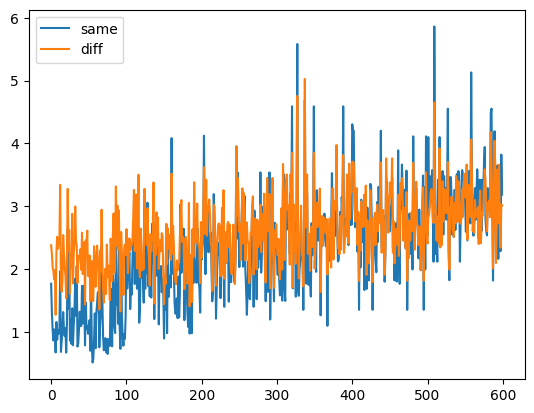

In [ ]:
losses_same_real = []
losses_diff_real = []
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.random.seed(41)

for num_char in range(2, 8):
    print(num_char)

    for j in range(100):
        img_idx = np.random.randint(len(data_train.img_paths))
        img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)

        same_style = data_train.wids[wid]

        same_word_paths = [item[0] for item in same_style if (item[1] == tokenizer.decode(gt_label)) and (item[0] != data_train.img_paths[img_idx][0])]
        diff_word_paths = [item[0] for item in same_style if (item[1] != tokenizer.decode(gt_label)) and (len(item[1]) != len(tokenizer.decode(gt_label)))]
        
        tries = 0
        while True:
            img_idx = np.random.randint(len(data_train.img_paths))
            img, gen_input, gt_label, wid = data_train.__getitem__(img_idx)

            if len(tokenizer.decode(gt_label)) == num_char:
                same_style = data_train.wids[wid]
                text_label = tokenizer.decode(gt_label)

                same_word_paths = [item[0] for item in same_style if (item[1] == text_label) and (item[0] != data_train.img_paths[img_idx][0])]
                diff_word_paths = [item[0] for item in same_style if (item[1] != text_label) and (len(item[1]) != len(text_label))]

                if len(same_word_paths) >= 1:
                    break
            tries += 1

            if tries >= 5000:
                break
        print(tokenizer.decode(gt_label), len(same_word_paths))
        

        loss_same = 0
        if len(same_word_paths) >= 1:
            for path in same_word_paths:
                img_same = 255 - cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                
                img_same = data_train.transforms(img_same).cuda()
                img = img.cuda()
                loss_same += loss_class.loss_func(img_same, img).detach().cpu()
            losses_same_real.append(loss_same/len(same_word_paths))
        
        loss_diff = 0
        if len(diff_word_paths) >= 1:
            for path in diff_word_paths:
                img_diff = 255 - cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                
                img_diff = data_train.transforms(img_diff).cuda()
                img = img.cuda()
                loss_diff += loss_class.loss_func(img_diff, img).detach().cpu()
            losses_diff_real.append(loss_diff/len(diff_word_paths))

plt.plot(losses_same_real, label="same")
plt.plot(losses_diff_real, label='diff')
plt.legend()
plt.xlabel("Num of images")
plt.ylabel("VGG16-8 loss")
plt.title("VGG16 loss between same- and different word images (real)")
plt.savefig("./vgg_loss_data_real.png")
plt.show()
    
